# Setup

In [7]:
# !proxychains pip install langchain-tavily

In [8]:
from langfuse.callback import CallbackHandler

langfuse_handler = CallbackHandler(
  secret_key="sk-lf-97826ab0-bdc0-4159-a34b-20c4ef35f598",
  public_key="pk-lf-ba431a2c-da14-42c0-9e43-5af9e5f4d126",
  host="https://cloud.langfuse.com"
)

# chain.invoke({"input": "<user_input>"}, config={"callbacks": [langfuse_handler]})

In [9]:
from dotenv import load_dotenv
load_dotenv()

True

In [10]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [11]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [40]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_results=2)

In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# tools

In [43]:
from langgraph.types import Command, interrupt
from langchain.tools import tool

In [45]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]
    
tools = [search_tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

# graph

In [46]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

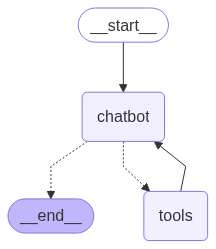

In [47]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile(checkpointer=memory)
graph

# Usage

In [23]:
config = {"configurable": {"thread_id": "1"}}

In [24]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! How can I assist you today?


In [26]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, Will! I remember your name. How can I assist you today?


In [27]:
user_input = "Do you know anything about agentic programming?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you know anything about agentic programming?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_HWMo0SeoZ4dFS3czfZXvulSD)
 Call ID: call_HWMo0SeoZ4dFS3czfZXvulSD
  Args:
    query: agentic programming
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "agentic programming", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Agent-oriented_programming", "title": "Agent-oriented programming - Wikipedia", "content": "Agent-oriented programming (AOP) is a programming paradigm where the construction of the software is centered on the concept of software agents.", "score": 0.8482825, "raw_content": null}, {"url": "https://www.riis.com/blog/introduction-to-agentic-programming-part-1", "title": "Introdu

In [36]:
snapshot = graph.get_state(config)
for message in snapshot.values["messages"]:
    print(message.pretty_print())

================================ Human Message =================================

Hi there! My name is Will.
None
================================== Ai Message ==================================

Hello, Will! How can I assist you today?
None
================================ Human Message =================================

Hi there! My name is Will.
None
================================== Ai Message ==================================

Hello again, Will! How can I help you today?
None
================================ Human Message =================================

Remember my name?
None
================================== Ai Message ==================================

Yes, Will! I remember your name. How can I assist you today?
None
================================ Human Message =================================

Do you know anything about agentic programming?
None
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_HWMo0SeoZ

# Usage with human intruption

In [49]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_BZApKqtJERUtBdNs6OBqdUcN)
 Call ID: call_BZApKqtJERUtBdNs6OBqdUcN
  Args:
    query: I need expert guidance for building an AI agent. Can you provide assistance or resources for this?


In [50]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [51]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_BZApKqtJERUtBdNs6OBqdUcN)
 Call ID: call_BZApKqtJERUtBdNs6OBqdUcN
  Args:
    query: I need expert guidance for building an AI agent. Can you provide assistance or resources for this?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I've reached out for expert guidance, and they recommend checking out **LangGraph** for building your AI agent. LangGraph is noted for being more reliable and extensible compared to simpler autonomous agents.

If you need further assistance or have more specific questions, feel free to ask!


In [10]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [11]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [31]:
from langchain_core.tools import tool
from langchain_core.tools import ToolException

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


@tool
def calculator(query):
    """Useful for performing basic math calculations. Input should be a valid math expression like '2 + 2'."""

    return eval(query)


@tool
def get_weather(city: str) -> int:
    """Get weather for the given city."""
    raise ToolException(f"Error: There is no city by the name of {city}.")

tools = [retrieve, calculator, get_weather]

In [32]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState, StateGraph

def query_or_respond(state: MessagesState):
    """Generate tool call or respond."""
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

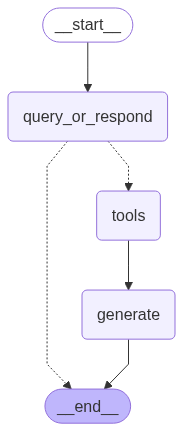

In [33]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(ToolNode(tools))
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)


memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
graph

In [35]:
import uuid
thread_id = str(uuid.uuid4())
config={
    "callbacks": [langfuse_handler],
    "configurable": {"thread_id": thread_id},
    "metadata": {"langfuse_session_id": thread_id},
}

In [36]:
input_message = "20424 * 3"

for step in graph.stream(
    {"messages": [{"role": "human", "content": input_message}]},
    stream_mode="values",
    config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

20424 * 3
================================== Ai Message ==================================
Tool Calls:
  calculator (call_mFnBLqYytJ6cYArkTUQuBbbB)
 Call ID: call_mFnBLqYytJ6cYArkTUQuBbbB
  Args:
    query: 20424 * 3
================================= Tool Message =================================
Name: calculator

61272
================================== Ai Message ==================================

20424 * 3 equals 61272.


In [37]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "human", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_9oKnotSiyON2c8N5Y6lJ34Xa)
 Call ID: call_9oKnotSiyON2c8N5Y6lJ34Xa
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to des

In [38]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_u8466tsXnzrnXaffqqqZYhc9)
 Call ID: call_u8466tsXnzrnXaffqqqZYhc9
  Args:
    query: common ways of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as

In [39]:
input_message = "weather condition in paris"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

weather condition in paris
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_olu3E8WnKK2YsRI5t7BKkV3k)
 Call ID: call_olu3E8WnKK2YsRI5t7BKkV3k
  Args:
    city: Paris
================================= Tool Message =================================
Name: get_weather

Error: ToolException('Error: There is no city by the name of Paris.')
 Please fix your mistakes.
================================== Ai Message ==================================

I don't know.


In [40]:
input_message = "Hi can you help me please?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hi can you help me please?
================================== Ai Message ==================================

Of course! How can I assist you today?


In [46]:
tools = [retrieve, calculator, get_weather]

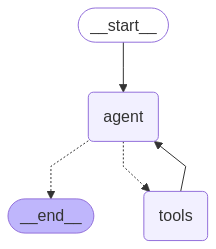

In [47]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, checkpointer=memory)
agent_executor

In [49]:
import uuid
thread_id = str(uuid.uuid4())
config={
    "callbacks": [langfuse_handler],
    "configurable": {"thread_id": thread_id},
    "metadata": {"langfuse_session_id": thread_id},
}

In [50]:
input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
    "whether condition in paris"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.whether condition in paris
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_8rSoDoTUkqzv7787lmcFwAPo)
 Call ID: call_8rSoDoTUkqzv7787lmcFwAPo
  Args:
    query: standard method for Task Decomposition
  get_weather (call_3gaD3j6fF2QVnMzfqmDMPivx)
 Call ID: call_3gaD3j6fF2QVnMzfqmDMPivx
  Args:
    city: Paris
================================= Tool Message =================================
Name: get_weather

Error: ToolException('Error: There is no city by the name of Paris.')
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_ofIq7ZYzCWj4AzWQnVJnH4Vr)
 Call ID: call_ofIq7ZYzCWj4AzWQnVJnH4Vr
  Args:
    query: standard method for Task Decompositi